# Creating the External Forcing Conditions

This notebook provides an example for creating external forcing conditions in a regional model. The example in this notebook is for the external forcing conditions that will be used in Mike's California regional model..

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file and the initial conditions file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\input'

## External Forcing Source Files
For this example, I will use the external forcing fields from the ECCO Version 5 state estimate. I will prepare these fields in 5 steps:
1. download 7 external forcing fields used in the ECCO model
2. read the external forcing fields used in the ECCO model as well as the ECCO grid
3. read in the bathymetry for my model as well as its grid
4. interpolate the ECCO fields onto my model grid and store each as a binary file
5. plot the interpolated fields to ensure they look as expected

### Step 1: Download the ECCO external forcing fields
To begin, download the ECCO external forcing fields used in the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/era_xx). For my model, I downloaded the following list of files for my year of interest (2004):
| Variable | File Name |
| -------- | --------- |
|ATEMP|EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl|
|AQH|EIG_spfh2m_plus_ECCO_v4r1_ctrl|
|SWDOWN|EIG_dsw_plus_ECCO_v4r1_ctrl|
|LWDOWN|EIG_dlw_plus_ECCO_v4r1_ctrl|
|UWIND|EIG_u10m|
|VWIND|EIG_v10m|
|PRECIP|EIG_rain_plus_ECCO_v4r1_ctrl|

Define the location where these grids are stored:

In [3]:
data_folder = 'C:\\Users\\azure\\Documents\\CS185C\\project\\data'

### Step 2: Read in the external forcing fields
To read in the ECCO fields, I will rely on the `exf` module from the `eccoseas` package. I import them here:

In [4]:
import sys 
sys.path.append('C:\\Users\\azure')
from eccoseas.ecco import exf

Next, I will loop through all of the files I downloaded, reading them in with the `exf` module.

In [5]:
# make a file dictionary to loop over
file_prefix_dict = {'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
             'AQH':'EIG_spfh2m_plus_ECCO_v4r1_ctrl',
             'SWDOWN':'EIG_dsw_plus_ECCO_v4r1_ctrl',
             'LWDOWN':'EIG_dlw_plus_ECCO_v4r1_ctrl',
             'UWIND':'EIG_u10m',
             'VWIND':'EIG_v10m',
             'PRECIP':'EIG_rain_plus_ECCO_v4r1_ctrl'}

variable_names = list(file_prefix_dict.keys())

In [6]:
# make a list to hold all of the exf grid
exf_grids = []
year=2004

# loop through each variable to read in the grid
for field in variable_names:
    exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(data_folder, file_prefix_dict[field], year)
    exf_grids.append(exf_grid)

With an eye toward the interpolation that will come in step 4, I will make 2D grids of longitudes and latitudes to use in the interpolation

In [7]:
Exf_Lon, Exf_Lat = np.meshgrid(exf_lon, exf_lat)
ecco_points = np.column_stack([Exf_Lon.ravel(), Exf_Lat.ravel()])

In addition, I will make a mask to determine where the interpolation will take place. Since the external forcing conditions are provided everywhere, I just set the entire grid to 1:

In [8]:
ecco_mask = np.ones((np.size(Exf_Lon),))

### Step 3: Read in the Model Grid
Next, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [9]:
# define the parameters that will be used in the data file
delX = 1/40
delY = 1/40
xgOrigin = 105.5
ygOrigin = 18.5
n_rows = 140
n_cols = 180

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'TG_bathymetry.bin'),'>f4').reshape(np.shape(XC))

Similar to above, I will make a mask to determine where the interpolatation will take place. I will create this mask using the `hFac` module from the `eccoseas` package: 

In [10]:
from eccoseas.downscale import hFac

In [11]:
surface_mask = hFac.create_surface_hFacC_grid(bathy, delR=1)

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

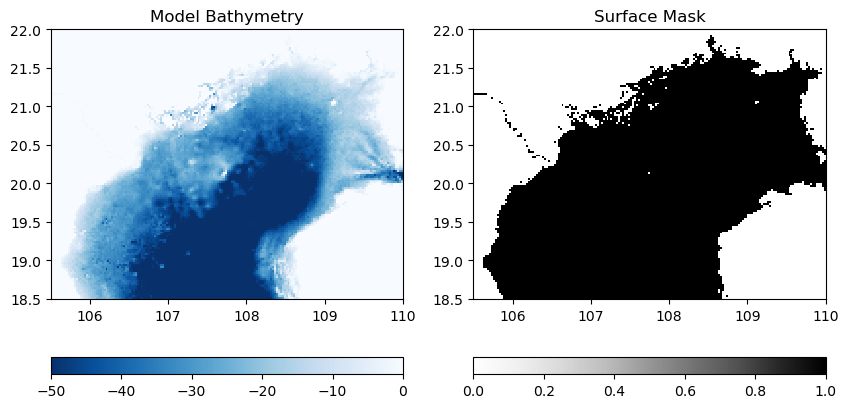

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-50, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

### Step 4: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [13]:
from eccoseas.downscale import horizontal

#### &#x2757; Warning
This code block may take a while to run. Further, it will generate 7 files sized ~500MB. Plan accordingly.

In [14]:
# ensure the output folder exists
if 'exf' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir, 'exf'))

In [15]:
# loop through each variable and corresponding ECCO grid
for variable_name, exf_grid in zip(variable_names, exf_grids):

    # create a grid of zeros to fill in
    interpolated_grid = np.zeros((np.shape(exf_grid)[0], np.shape(XC)[0], np.shape(XC)[1]))

    # loop through each timestep to generate the interpolated grid
    for timestep in range(1):

        # grab the values for this timestep and run the interpolation function
        ecco_values = exf_grid[timestep, :, :].ravel()
        interp_timestep = horizontal.downscale_2D_points_with_zeros(ecco_points, ecco_values, ecco_mask,
                                                                    XC, YC, surface_mask)
        interpolated_grid[timestep,:,:] = interp_timestep

    # convert ECCO values to MITgcm defaults
    if variable_name=='ATEMP':
        interpolated_grid += 273.15
    if variable_name in ['SWDOWN','LWDOWN']:
        interpolated_grid *=-1

    # output the interpolated grid
    output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

### Step 5: Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [16]:
meta_dict = {'ATEMP':[280, 295, cm.thermal, '$^{\circ}$C'],
             'AQH':[0.010, 0.013, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 5e-9, cm.tempo, 'm/s'],
             'SWDOWN':[0,600,cm.solar,'W/m$^2$'],
             'LWDOWN':[200, 400,cm.solar,'W/m$^2$'],
             'UWIND':[-6, 6, cm.balance, 'm/s'],
             'VWIND':[-5, 5, cm.balance, 'm/s'],
             'RUNOFF':[0, 1e-6, cm.tempo, 'm/s']}

Then, I'll create all of the subplots:

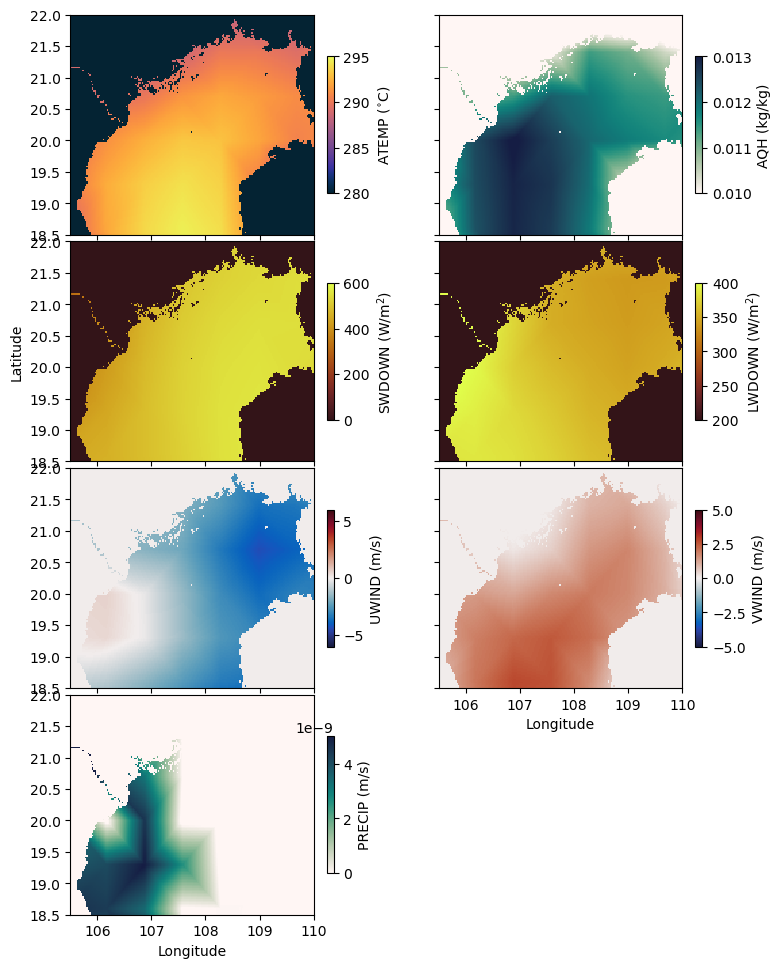

In [17]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    CA_exf_grid = CA_exf_grid.reshape((np.shape(exf_grid)[0],np.shape(XC)[0], np.shape(XC)[1]))

    # choose just the first timestep for plotting
    CA_exf_grid = CA_exf_grid[0, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, CA_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

For my model, I will also be running a version without wind or precipitation, to remove factors that might add to the erosion of karst formations in Ha Long Bay.

In [18]:
# make a zero zonal wind file
u_grid = np.fromfile(os.path.join(input_dir,'exf','UWIND_'+str(year)),'>f4')
u_grid*=0
u_grid.ravel('C').astype('>f4').tofile(os.path.join(input_dir,'exf','UWIND_zero_'+str(year)))


# make a zero meridional wind file
v_grid = np.fromfile(os.path.join(input_dir,'exf','VWIND_'+str(year)),'>f4')
v_grid*=0
v_grid.ravel('C').astype('>f4').tofile(os.path.join(input_dir,'exf','VWIND_zero_'+str(year)))

# make a zero precipitation file
precip_grid = np.fromfile(os.path.join(input_dir,'exf','PRECIP_'+str(year)),'>f4')
precip_grid*=0
precip_grid.ravel('C').astype('>f4').tofile(os.path.join(input_dir,'exf','PRECIP_zero_'+str(year)))